In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report,roc_curve, roc_auc_score,auc

## RandomForest

### 1.数据集加载

In [2]:
data = pd.read_csv('./dataset/creditcard.csv')

# 将Amount标准化，并将不需要用到的Time去掉
data[['Amount']] = StandardScaler().fit_transform(data[['Amount']])
data=data.loc[:,data.columns!='Time']
data.head()

# 分离特征和标签
X = data.loc[:, data.columns != 'Class']
y = data['Class']

### 2.训练集、测试集划分

In [3]:
X_train, X_test, y_train, y_test = \
                   train_test_split(X,y,test_size = 0.3, 
                                    random_state = 0)

### 3. 模型
#### 3.1 下采样

In [4]:
# 计算少数类个数
number_records_fraud = len(data[data.Class == 1])
# 取得少数类样本的索引
fraud_indices = np.array(data[data.Class == 1].index)
# 取得多数类样本的索引
normal_indices = data[data.Class == 0].index

# 从多数类中随机选择与少数类个数相同的样本数作为样本
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# 合并随机取得的0类和全部的1类的索引
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# 根据索引得到下采样后的数据集
under_sample_data = data.iloc[under_sample_indices,:]

# 分离特征和标签
X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

print("正样本比例(0类): ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("负样本比例(1类): ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("下采样后总样本个数为: ", len(under_sample_data))

正样本比例(0类):  0.5
负样本比例(1类):  0.5
下采样后总样本个数为:  984


In [5]:
# 下采样
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = \
                                                train_test_split(X_undersample,
                                                                 y_undersample,
                                                                 test_size = 0.3,
                                                                 random_state = 0)


In [6]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = random_forest.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
print("混淆矩阵：",cnf_matrix)
np.set_printoptions(precision=2)

print(classification_report(y_test,y_pred_undersample))
print("测试集Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred_undersample)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ("AUC值：",roc_auc)

混淆矩阵： [[82347  2949]
 [    5   142]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85296
           1       0.05      0.97      0.09       147

    accuracy                           0.97     85443
   macro avg       0.52      0.97      0.54     85443
weighted avg       1.00      0.97      0.98     85443

测试集Recall:  0.9659863945578231
AUC值： 0.9657063374027157


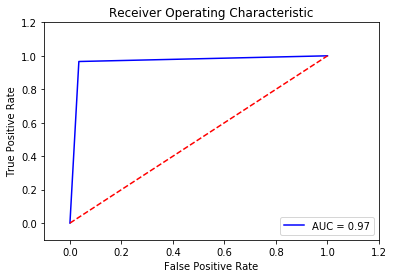

In [7]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('./result_img/RF_subsample.png',bbox_inches="tight")

#### 3.2 上采样

In [8]:
from imblearn.over_sampling import SMOTE
X_train_oversample, y_train_oversample = SMOTE().fit_sample(X_train, y_train)
random_forest2 = RandomForestClassifier(n_estimators=100)
random_forest2.fit(X_train_oversample,y_train_oversample.values.ravel())
y_pred_oversample = random_forest2.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_oversample)
print("混淆矩阵：",cnf_matrix)
np.set_printoptions(precision=2)

print(classification_report(y_test,y_pred_oversample))
print("测试集Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred_oversample)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ("AUC值：",roc_auc)

Using TensorFlow backend.


混淆矩阵： [[85285    11]
 [   27   120]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.92      0.82      0.86       147

    accuracy                           1.00     85443
   macro avg       0.96      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443

测试集Recall:  0.8163265306122449
AUC值： 0.9080987839705381


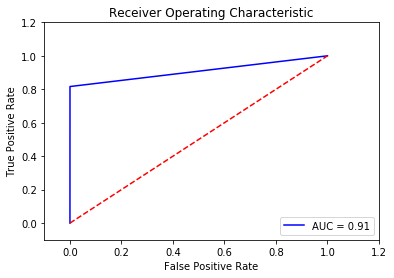

In [9]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('./result_img/RF_oversample.png',bbox_inches="tight")

#### 3.3 不进行采样

In [10]:
# 未采样
random_forest3 = RandomForestClassifier(n_estimators=100)
random_forest3.fit(X_train,y_train.values.ravel())
y_pred = random_forest3.predict(X_test.values)

# 计算混淆矩阵
cnf_matrix = confusion_matrix(y_test,y_pred)
print("混淆矩阵：",cnf_matrix)
np.set_printoptions(precision=2)
print(classification_report(y_test,y_pred))
print("测试集Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ("AUC值：",roc_auc)

混淆矩阵： [[85289     7]
 [   36   111]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.94      0.76      0.84       147

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

测试集Recall:  0.7551020408163265
AUC值： 0.8775099868309733


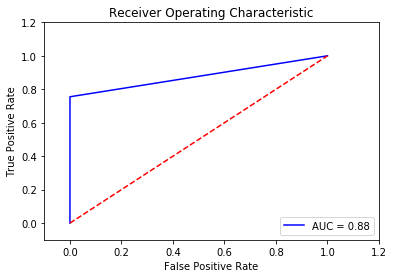

In [11]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('./result_img/RF_without_sample.png',bbox_inches="tight")